### prev_application 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가

#### 라이브러리 및 데이터 세트 로딩. 이전 application 데이터의 FE 함수 복사

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [2]:
app_test = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_test.csv')
app_train = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_train.csv')

In [3]:
def get_apps_dataset():
    app_test = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_test.csv')
    app_train = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_train.csv')
    apps = pd.concat([app_train, app_test])
    
    return apps

apps = get_apps_dataset()

In [4]:
apps.tail(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48741,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-15922,-3037,-2681.0,-1504,4.0,1,1,0,1,1,0,NaN,3.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.733503,0.632770,0.283712,0.1113,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1383,NaN,0.0542,0.1134,0.1415,0.9955,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1441,NaN,0.0574,0.1124,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1408,NaN,0.0554,NaN,block of flats,0.1663,"Stone, brick",No,0.0,0.0,0.0,0.0,-838.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,Family,Commercial associate,Higher education,Married,House / apartment,0.018850,-13968,-2731,-1461.0,-1364,NaN,1,1,1,1,1,0,Managers,2.0,2,2,MONDAY,10,0,1,1,0,1,1,Self-employed,0.373090,0.445701,0.595456,0.1629,0.0723,0.9896,NaN,NaN,0.16,0.0690,0.6250,NaN,NaN,NaN,0.1563,NaN,0.1490,0.1660,0.0750,0.9896,NaN,NaN,0.1611,0.0690,0.6250,NaN,NaN,NaN,0.1204,NaN,0.1577,0.1645,0.0723,0.9896,NaN,NaN,0.16,0.0690,0.6250,NaN,NaN,NaN,0.1591,NaN,0.1521,NaN,block of flats,0.1974,Panel,No,0.0,0.0,0.0,0.0,-2308.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
48743,456250,NaN,Cash loans,F,Y,N,0,135000.0,312768.0,24709.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006629,-13962,-633,-1072.0,-4220,22.0,1,1,1,1,0,0,Core staff,2.0,2,2,TUESDAY,14,0,0,0,0,0,0,Government,NaN,0.456541,0.272134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-327.0,0,1,0,0,0,

#### 이전 application 데이터의 feature engineering 함수 복사

In [5]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

##### previous 데이터 로딩

In [6]:
prev = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/previous_application.csv')
print(prev.shape, apps.shape)

(1670214, 37) (356255, 122)


In [7]:
prev.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


##### application와 previous outer 조인하고 누락된 집합들 확인. 

In [8]:
app = apps.merge(prev,on='SK_ID_CURR',how='outer')
app.shape

(1687612, 158)

In [9]:
app.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_y,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1038818.0,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9.0,Y,1.0,0.0,NaN,NaN,XAP,Approved,-606.0,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House /

In [10]:
app['SK_ID_PREV'].isnull().sum()
# 356255 건 중에 17398 은 과거 대출 이력이 없음

17398

### previous 컬럼 설명

|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|previous_application.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|previous_application.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|previous_application.csv|NAME_CONTRACT_TYPE|대출|대출 유형|대출 유형|
|previous_application.csv|AMT_ANNUITY|대출|대출 금액|월 대출 지급액|
|previous_application.csv|AMT_APPLICATION|대출|대출 금액|대출 신청 금액|
|previous_application.csv|AMT_CREDIT|대출|대출 금액|대출금액(허가)|
|previous_application.csv|AMT_DOWN_PAYMENT|대출|대출 금액|대출 시 납부한 선금액|
|previous_application.csv|AMT_GOODS_PRICE|대출|대출 금액|소비자 대출상품액|
|previous_application.csv|WEEKDAY_APPR_PROCESS_START|고객|행동|대출 신청 시작 요일|
|previous_application.csv|HOUR_APPR_PROCESS_START|고객|행동|대출 신청 시작 시간대|
|previous_application.csv|FLAG_LAST_APPL_PER_CONTRACT|고객|행동|이전 계약의 마지막 대출 신청 여부|
|previous_application.csv|NFLAG_LAST_APPL_IN_DAY|고객|행동|하루중 마지막 대출 신청 여부(하루에 여러 번 대출 신청했을 경우)|
|previous_application.csv|NFLAG_MICRO_CASH|대출|대출 유형|소액 대출 여부|
|previous_application.csv|RATE_DOWN_PAYMENT|대출|대출 금액|선금 비율(정규화됨)|
|previous_application.csv|RATE_INTEREST_PRIMARY|대출|대출 금액|이자율|
|previous_application.csv|RATE_INTEREST_PRIVILEGED|대출|대출 금액|이자율|
|previous_application.csv|NAME_CASH_LOAN_PURPOSE|대출|대출 유형|현금 대출 목적|
|previous_application.csv|NAME_CONTRACT_STATUS|대출|대출 상태|대출 상태(허가, 취소)|
|previous_application.csv|DAYS_DECISION|대출|대출 상태|과거 신청 대비 현재 신청 결정 기간|
|previous_application.csv|NAME_PAYMENT_TYPE|대출|대출 유형|과거 대출 신청의 납부 방법|
|previous_application.csv|CODE_REJECT_REASON|대출|대출 상태|과거 신청 거절 사유|
|previous_application.csv|NAME_TYPE_SUITE|고객|행동(추천)|동행 고객|
|previous_application.csv|NAME_CLIENT_TYPE|고객|행동|신규 고객 또는 기존 대출 고객 여부|
|previous_application.csv|NAME_GOODS_CATEGORY|대출|대출 유형|대출 상품 중분류 유형|
|previous_application.csv|NAME_PORTFOLIO|대출|대출 유형|현금대출/POS/CAR 대출 유형|
|previous_application.csv|NAME_PRODUCT_TYPE|채널|판매 유형|고객이 찾아온 대출인가, 영업 대출인가|
|previous_application.csv|CHANNEL_TYPE|채널|채널 유형|채널 유형|
|previous_application.csv|SELLERPLACE_AREA|채널|채널 유형|판매자 판매 지역|
|previous_application.csv|NAME_SELLER_INDUSTRY|채널|채널 유형|판매자 Industry|
|previous_application.csv|CNT_PAYMENT|대출|대출 금액|이전 대출 신청의 대출금액 관련 Term|
|previous_application.csv|NAME_YIELD_GROUP|대출|대출 금액|집단 금리 적용 유형|
|previous_application.csv|PRODUCT_COMBINATION|대출|대출 유형|이전 대출 결합 상품|
|previous_application.csv|DAYS_FIRST_DRAWING|대출|상태|신청날짜부터 최초 대출 지급까지의 일자|
|previous_application.csv|DAYS_FIRST_DUE|대출|상태|신청날짜부터 마감일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE_1ST_VERSION|대출|상태|신청날짜부터 첫 만기일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE|대출|상태|신청날짜부터 마지막 만기일까지의 일자|
|previous_application.csv|DAYS_TERMINATION|대출|상태|현 대출 신청일자 대비 대출 예상 종료 일자|
|previous_application.csv|NFLAG_INSURED_ON_APPROVAL|대출|상태|대출 신청 시 보험가입 요청여부|


##### previous 컬럼과 Null 값 조사 

In [11]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### 주요 컬럼 EDA 수행

##### SK_ID_CURR당 평균 SK_ID_PREV 건수 구하기
* groupby 로 평균 건수 구함. 
* boxplot으로 시각화

In [12]:
prev_group = app.groupby('SK_ID_CURR')
type(prev_group)

pandas.core.groupby.generic.DataFrameGroupBy

In [13]:
prev_group['SK_ID_PREV'].count().mean()

4.688254199941054

In [14]:
prev_count = prev_group['SK_ID_PREV'].count()
print(prev_count)

SK_ID_CURR
100001    1
100002    1
100003    3
100004    1
100005    2
         ..
456251    1
456252    1
456253    2
456254    2
456255    8
Name: SK_ID_PREV, Length: 356255, dtype: int64


<AxesSubplot:>

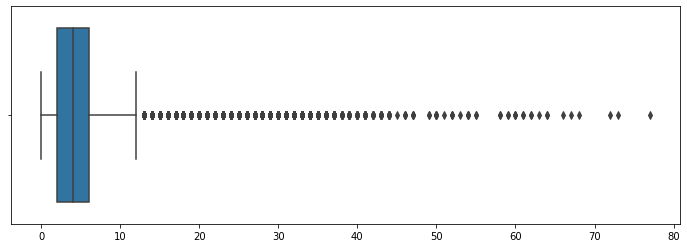

In [15]:
fig = plt.subplots(figsize=(12,4))
sns.boxplot(x=prev_count.values)

#### 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

* application_train의 TARGET 값을 가져오기 위해 prev와 app_train을 inner join 후 TARGET 유형에 따라 비교
* 숫자형 컬럼명 필터링

In [16]:
app_train_target = app_train[['SK_ID_CURR','TARGET']]
app = prev.merge(app_train_target, on = 'SK_ID_CURR', how='inner')

In [17]:
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0] )
        sns.displot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.displot(df[cond_1][column], ax=axs[0][1], label='1', color='red')   

In [18]:
app.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0
1,1696966,271877,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18,Y,1,0.101325,NaN,NaN,XAP,Refused,-472,Cash through the bank,SCO,NaN,Repeater,Clothing and Accessories,POS,XNA,Regional / Local,55,Furniture,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2154916,271877,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14,Y,1,0.000000,NaN,NaN,XAP,Approved,-548,Cash through the bank,XAP,NaN,New,Furniture,POS,XNA,Stone,196,Furniture,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,0


In [19]:
num_columns = app.dtypes[app.dtypes!='object'].index.tolist()
num_columns = [column for column in num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]

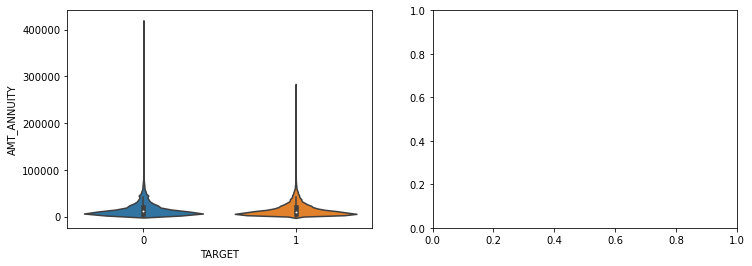

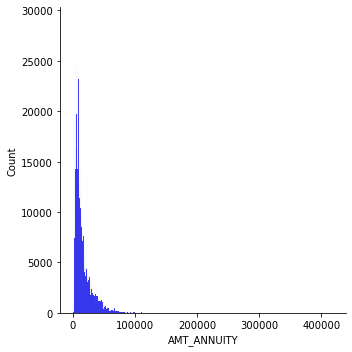

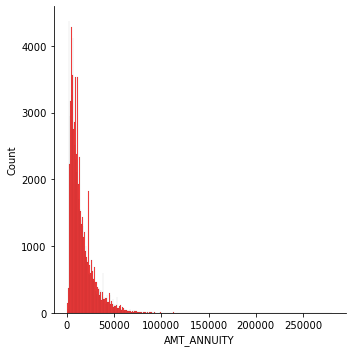

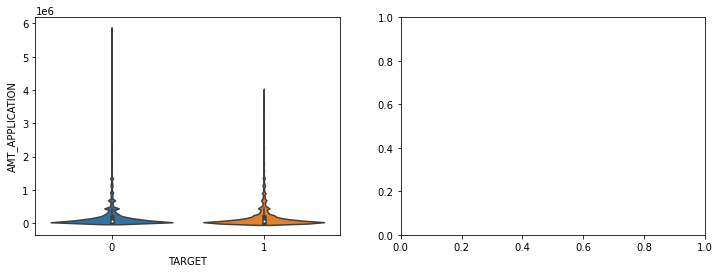

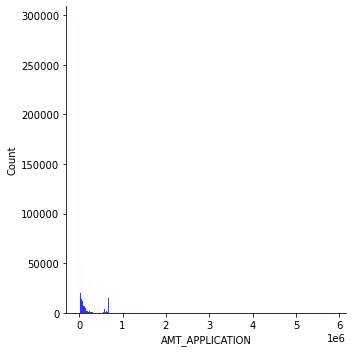

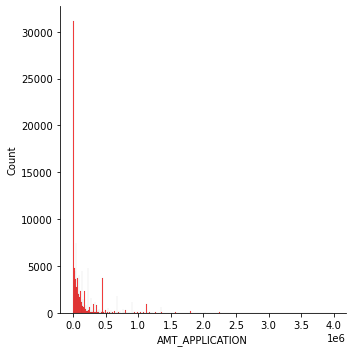

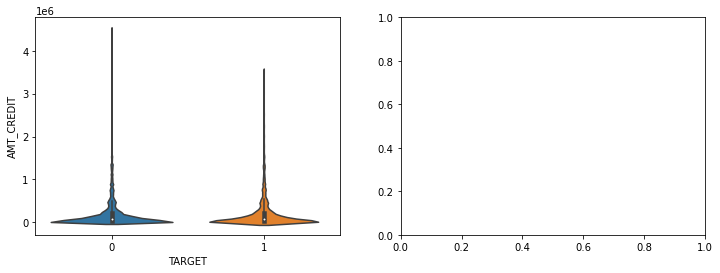

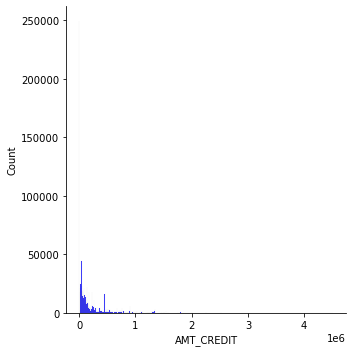

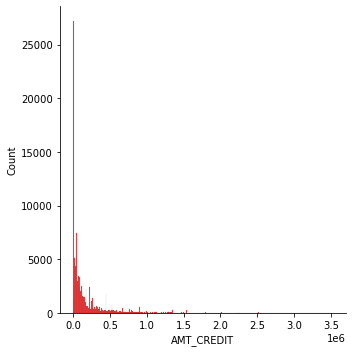

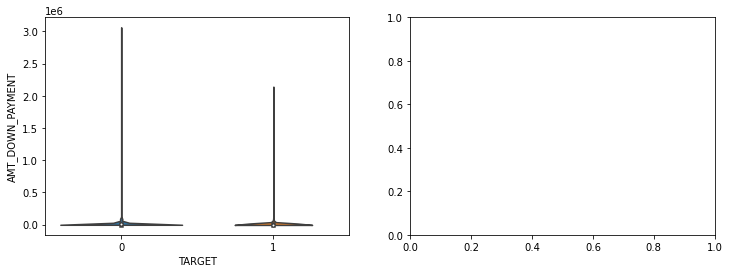

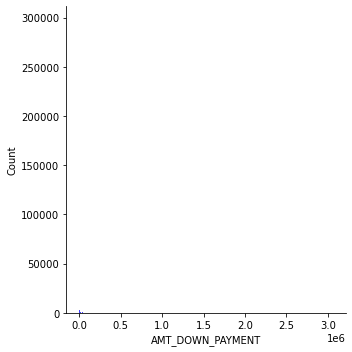

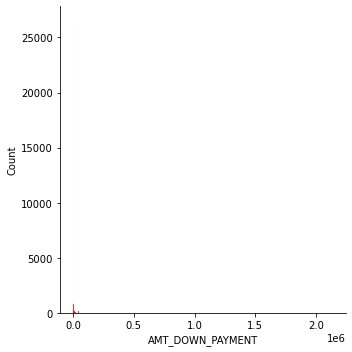

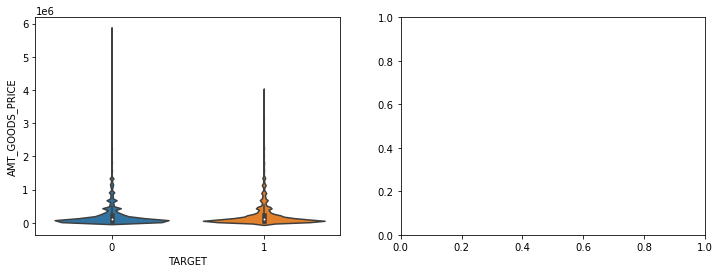

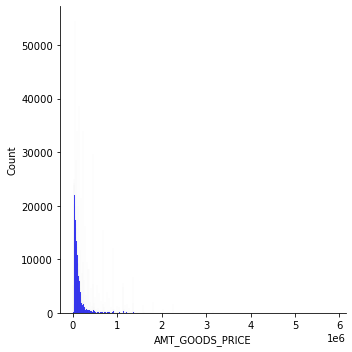

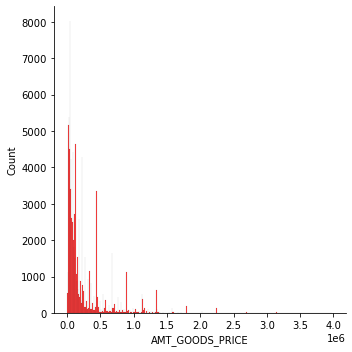

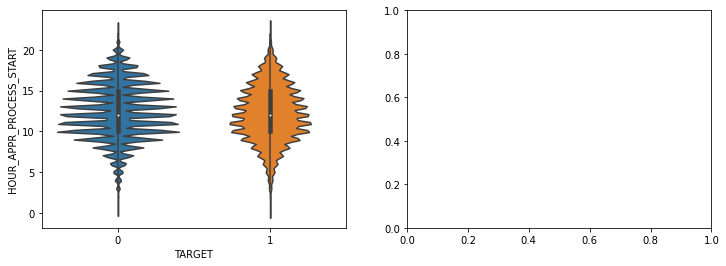

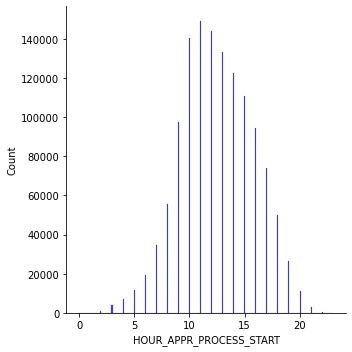

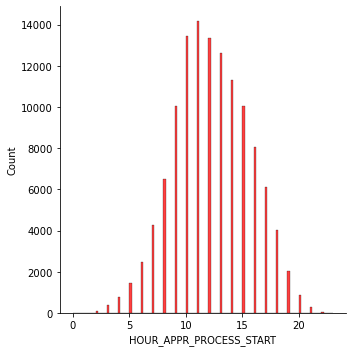

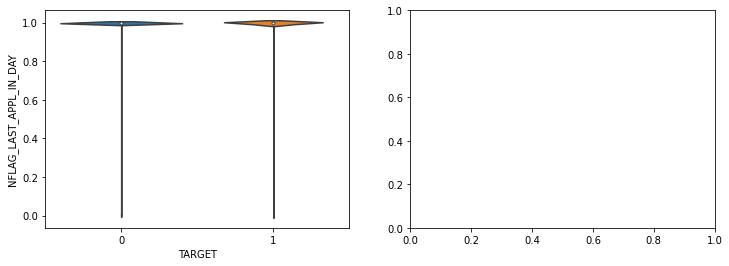

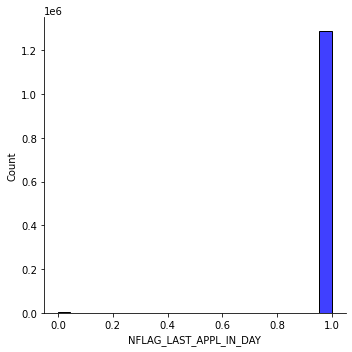

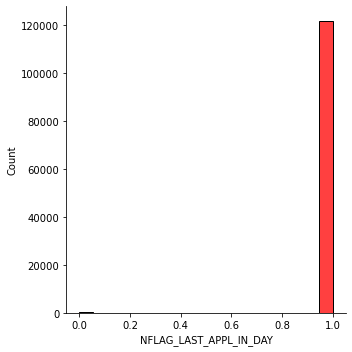

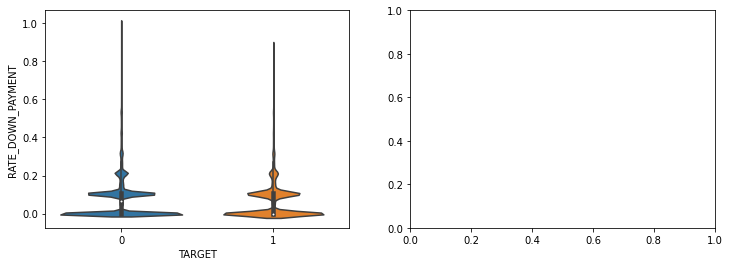

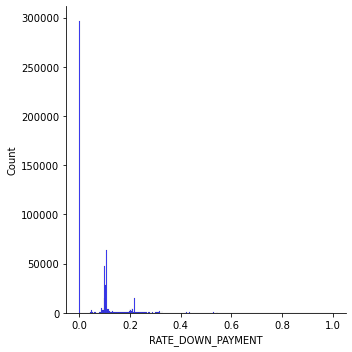

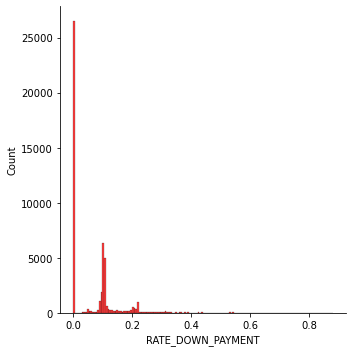

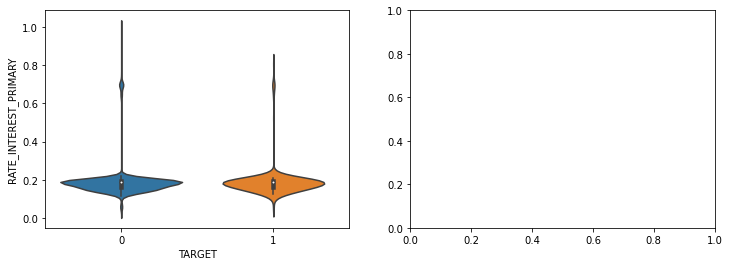

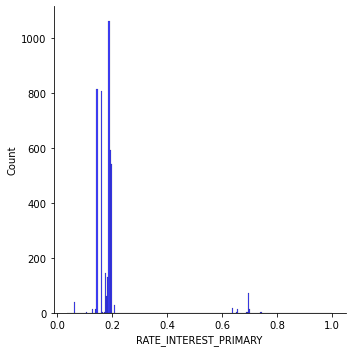

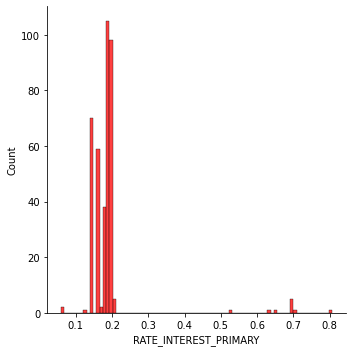

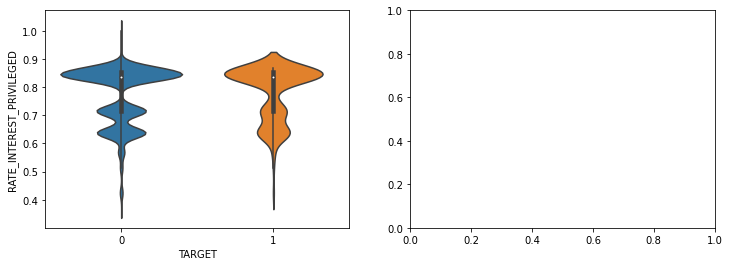

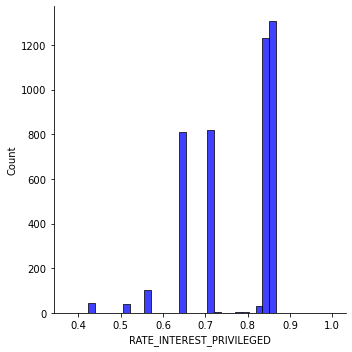

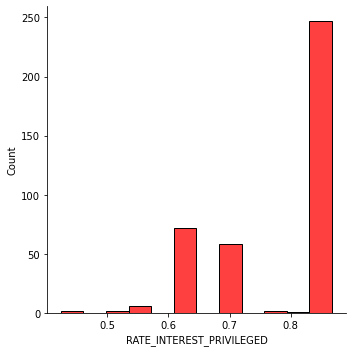

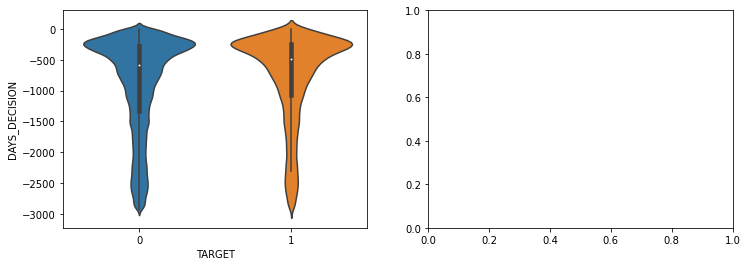

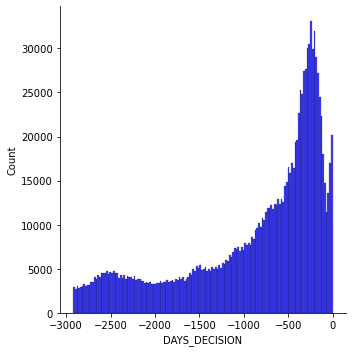

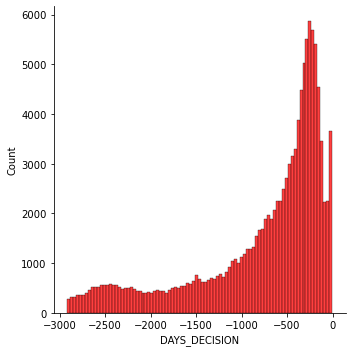

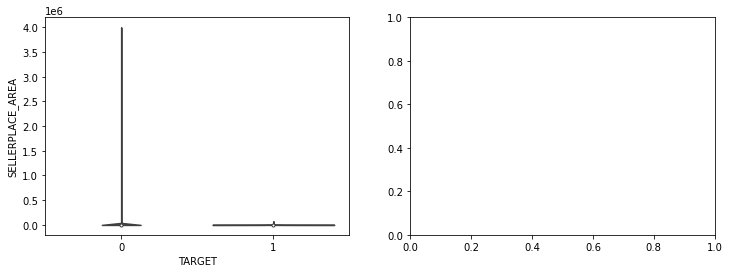

In [ ]:
show_hist_by_target(app, num_columns)

* AMT_ANNUITY, AMT_CREDIT, AMT_APPLICATION, AMT_GOODS_CREDIT는 TARGET=1일 경우에 소액 비율이 약간 높음(큰 차이는 아님)
* RATE_DOWN_PAYMENT는 큰 차이 없음. 
* RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED 는 NULL값이 매우 많아서 판단 어려움
* DAYS_DECISION은 TARGET=1일 때 0에 가까운(최근일)값이 약간 더 많음. 
* DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION은 365243 값이 매우 많음. 

#### Category 피처들의 Histogram을 TARGET 유형에 따라 비교

In [ ]:
object_columns = app_prev.dtypes[app_prev.dtypes=='object'].index.tolist()
object_columns

In [ ]:
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(app_prev, object_columns)

* NAME_CONTRACT_TYPE은 TARGET=1일때 CASH_LOAN의 비중이 약간 높음
* NAME_CONTRACT_STATUS(대출허가상태)는 TARGET=1일때 상대적으로 TARGET=0 대비 (당연히) Refused의 비율이 높음. 
* NAME_PAYMENT_TYPE(대출납부방법)는 TARGET=1일때 상대적으로 TARGET=0 대비 XNA의 비율이 약간 높음.

### prev 데이터 세트 feature engineering 수행. 
#### SQL 대비  Pandas groupby 사용 로직 비교

##### SQL로 SK_ID_CURR별 건수, 평균 AMT_CREDIT, 최대 AMT_CREDIT, 최소 AMT_CREDIT 구하기

In [ ]:
# select sk_id_curr, count(*), avg(amt_credit) , max(amt_credit), min(amt_credit) from previous group by sk_id_curr

##### pandas groupby 단일 aggregation 함수 사용
* groupby SK_ID_CURR
* SK_ID_CURR별 건수, AMT_CREDIT에 대한 평균, 최대 값

In [ ]:
prev_group = prev.groupby(['SK_ID_CURR'])

In [ ]:
prev_exercise = prev_group['AMT_CREDIT'].mean()
prev_exercise['AMT_CREDIT_MAX']= prev_group['AMT_CREDIT'].max()
prev_exercise['AMT_CREDIT_MIN']= prev_group['AMT_CREDIT'].min()

##### groupby agg()함수를 이용하여 여러개의 aggregation 함수 적용

In [ ]:
prev_group['AMT_CREDIT'].agg('mean','max','min')

##### agg()에 dictionary를 이용하여 groupby 적용

In [ ]:
agg = {'AMT_CREDIT':['mean','max','min']}
prev_group['AMT_CREDIT'].agg(agg)

In [ ]:
agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head()

##### grouby agg 로 만들어진  Multi index 컬럼 변경. 
* MultiIndex로 되어 있는 컬럼명 확인
* MultiIndex 컬럼명을 _로 연결하여 컬럼명 변경. 

##### prev 피처 가공. 대출 신청액 대비 다른 금액 차이 및 비율 생성. 

##### DAYS_XXX 피처의 365243 을 NULL로 변환하고, 첫번째 만기일과 마지막 만기일까지의 기간 가공

##### 기존 이자율 관련 컬럼이 null이 많아서 새롭게 간단한 이자율을 대출 금액과 대출 금액 납부 횟수를 기반으로 계산 

##### 기존 대출 금액, 대출 상태 관련 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행.

#### SK_ID_CURR별로 NAME_CONTRACT_STATUS가 Refused 일 경우의 건수 및 과거 대출건 대비 비율

#### Group by 기준  컬럼 기반에서 다른 컬럼들의 기준에 따라 세분화된 aggregation 수행. 

In [ ]:
prev['NAME_CONTRACT_STATUS'].value_counts()

##### SQL Group by Case when 과 pandas의 차이

In [ ]:
# SK_ID_CURR레벨로 groupby 된 count와  name_contract_status가 Refused일 때의 count 
'''select sk_id_curr, cnt_refused/cnt
from
(
    select sk_id_curr, count(*) cnt, count(case when name_contract_status == 'Refused' end) cnt_refused
    from previous group by sk_id_curr
) 
'''

##### Pandas는 원 DataFrame 에 groupby 적용된 DataFrame 과 세부기준으로 filtering 된 DataFrame에 groupby 적용된 DataFrame 을 조인하여 생성. 
* NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 및 filtering 된 DataFrame에 groupby 적용 
* groupby 완료 후 기존 prev_amt_agg와 조인
* 효율적인 오류 방지를 위해서 groupby 시 적용후 groupby key값을 DataFrame의 Index가 아닌 일반 컬럼으로 변경.

##### 계산된 PREV_REFUSED_COUNT 중 Null값은 0 으로 변경하고 SK_ID_CURR 개별 건수 대비 PREV_REFUSED_COUNT 비율 계산

##### 세부 레벨 groupby 와 unstack()을 이용하여 SQL Group by Case when 구현. 세부 조건이 2개 이상일때


###### SQL 일 경우
SELECT COUNT(CASE WHEN == 'Approved' END) , COUNT(CASE WHEN == 'Refused' END) FROM PREV GROUP BY SK_ID_CURR

##### Pandas로 수행

#####  컬럼명 변경, Null 처리, 그리고 기존의 prev_amt_agg와 조인 후 데이터 가공 

#### 가공된 최종 데이터 세트 생성
##### 이전에 application 데이터 세트의 feature engineering 수행 후 새롭게 previous 데이터 세트로 가공된 데이터를 조인. 

In [ ]:
apps_all =  get_apps_processed(apps)

In [ ]:
print(apps_all.shape, prev_agg.shape)
apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
print(apps_all.shape)

In [ ]:
apps_all.head()

In [ ]:
apps_all.info()

#### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음. 

In [ ]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
for column in object_columns:
    apps_all[column] = pd.factorize(apps_all[column])[0]

In [ ]:
apps_all.info()

#### 학습 데이터와 테스트 데이터 다시 분리

In [ ]:
apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
apps_all_test = apps_all[apps_all['TARGET'].isnull()]

apps_all_test = apps_all_test.drop('TARGET', axis=1)

In [ ]:
apps_all_train.columns.tolist()

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 

In [ ]:
from sklearn.model_selection import train_test_split

ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 50)

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit 수행. 

In [ ]:
preds = clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'prev_baseline_01.csv'), index=False)

#### 지금까지 만든 로직을 별도의 함수로 생성. 

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# 신청금액과 실제 대출액, 상품금액과의 차이 비율, 만기일 차이 비교, 이자율 계산등의 주요 컬럼 가공 생산. 
def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev

# 기존 컬럼및 위에서 가공된 신규 컬럼들에 대해서 SK_ID_CURR 레벨로 Aggregation 수행.  
def get_prev_amt_agg(prev):

    agg_dict = {
         # 기존 주요 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. . 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 신규 가공 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. .
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_amt_agg = prev_amt_agg.reset_index()
    
    return prev_amt_agg

# NAME_CONTRACT_STATUS의 SK_ID_CURR별 Approved, Refused의 건수 계산.  
def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
    
    return prev_refused_appr_agg

    
# 앞에서 구한 prev_amt_agg와 prev_refused_appr_agg를 조인하고 SK_ID_CURR별 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# apps와 previous 데이터 세트를 SK_ID_CURR레벨로 다양한 컬럼이 aggregation되어 있는 prev_agg 조인
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

# Label 인코딩 수행. 
def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

# 학습 데이터와 테스트 데이터 세트 분리. 
def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

# 학습 수행. 
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=32,
            subsample=0.8,
            max_depth=12,
            silent=-1,
            verbose=-1
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

##### 함수를 호출하여 재학습 및 평가 

In [ ]:
apps_all = get_apps_all_with_prev_agg(apps, prev)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
clf = train_apps_all(apps_all_train)


In [ ]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR','TARGET'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_03.csv', index=False)